In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.stats import truncnorm as trn 

%matplotlib inline

In [0]:
NB_train = pd.read_csv("/content/gdrive/My Drive/Current/NB_train_use.csv")
Xtrain = NB_train.to_numpy()

NB_test = pd.read_csv("/content/gdrive/My Drive/Current/NB_test_use.csv")
Xtest = NB_test.to_numpy()

y = Xtrain[:,-1]
X = Xtrain[:,:-1]
yt = Xtest[:,-1]
Xt = Xtest[:,:-1]

In [0]:
# globally used accuracy function. good for all models / labelled data and predicted label data
def accuracy(y, y_hat):
  return np.mean(y == y_hat)

In [0]:
# resetting data in order to convert to binary to  re-adjust parameter - cutoff
y = Xtrain[:,-1]
X = Xtrain[:,:-1]
yt = Xtest[:,-1]
Xt = Xtest[:,:-1]
## Bernoulli conversion to binary features
cutoff = .6
X = np.floor(cutoff + X / 256)
Xt = np.floor(cutoff + Xt / 256)

In [0]:
# using bernoulli distribution with input already convereted to binary
class BernoulliNB():
  # fitting model with training data. input data split into features, X, and labels, y
  def fit(self, X, y, epsilon = 1e-6):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))
    N, D = X.shape
    for k in self.K:
      X_k = X[y == k,:]
      eps = [epsilon] * D
      self.likelihoods[k] = {"Prob==1": np.maximum(eps, X_k.mean(axis = 0))}
      self.priors[k] = len(X_k) / len(X)
  # prediction function with test data. input is only features.      
  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))
    for k, l in self.likelihoods.items():
      P_hat[:, k] = np.matmul(np.log(l["Prob==1"]), X.T) + np.matmul(np.log(1 - l["Prob==1"]), (1 - X).T) + np.log(self.priors[k])
    return P_hat.argmax(axis=1)

In [0]:
# run bernoulli with binary train/test data
bnb = BernoulliNB()
bnb.fit(X, y)
y_hat = bnb.predict(Xt)
print(accuracy(yt, y_hat))


0.8466


In [0]:
## Naive Bayes with Gaussian distribution
class GaussNB():
  # fitting model with training data. input data split into features, X, and labels, y
  def fit(self, X, y, epsilon = 1175):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))
    for k in self.K:
      X_k = X[y == k, :]
      self.likelihoods[k] = {"Mean": X_k.mean(axis = 0), "Cov": X_k.var(axis=0) + epsilon}
      self.priors[k] = len(X_k) / len(X)
  # prediction function with test data. input is only features.
  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))
    for k, l in self.likelihoods.items():
      P_hat[:, k] = mvn.logpdf(X, l["Mean"], l["Cov"]) + np.log(self.priors[k])  
    return P_hat.argmax(axis=1)

In [0]:
# run either Gauss model with original train / test data
gnb = GaussNB()
gnb.fit(X, y)
y_hat = gnb.predict(Xt)
print(accuracy(yt, y_hat))


0.8138


In [0]:
## Bayes with Gaussian distribution
class GaussBayes():
  # fitting model with training data. input data split into features, X, and labels, y
  def fit(self, X, y, epsilon = 1175):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))
    for k in self.K:
      X_k = X[y == k, :]
      N_k, D = X_k.shape
      self.likelihoods[k] = {"Mean": X_k.mean(axis=0), "Cov": (1/(N_k - 1)) * np.matmul((X_k - X_k.mean(axis=0)).T, X_k - X_k.mean(axis=0)) 
      + epsilon*np.identity(D)}
      self.priors[k] = len(X_k) / len(X)
  # prediction function with test data. input is only features.
  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))
    for k, l in self.likelihoods.items():
      P_hat[:, k] = mvn.logpdf(X, l["Mean"], l["Cov"]) + np.log(self.priors[k])  
    return P_hat.argmax(axis=1)

In [0]:
# run either Gauss model with original train / test data
gnb = GaussBayes()
gnb.fit(X, y)
y_hat = gnb.predict(Xt)
print(accuracy(yt, y_hat))

0.9526


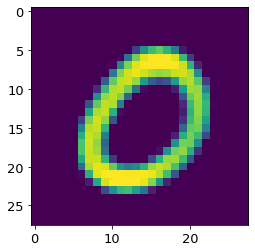

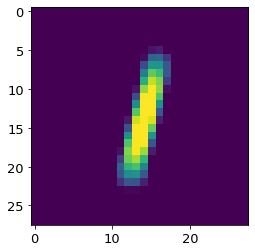

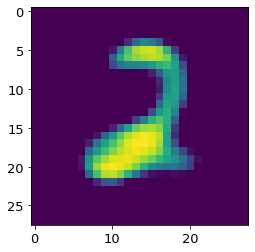

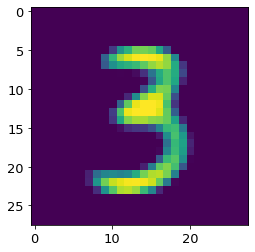

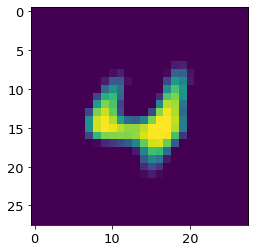

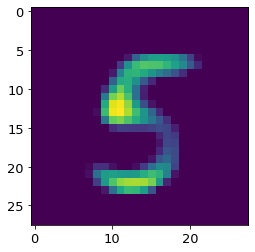

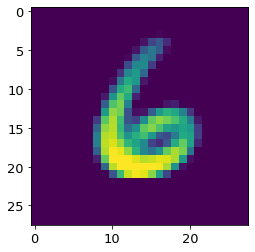

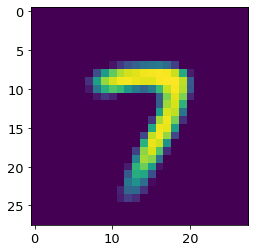

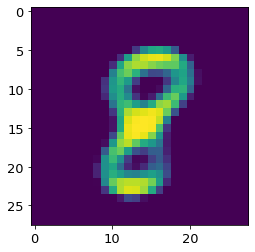

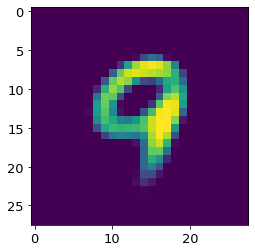

In [0]:
# graph training data by label with heat maps - using median
for j in range(10):
  temp = X[y==j,:]
  temp2 = np.zeros(784)
  temp3 = np.zeros((28,28))
  for i in range(784):
    temp2[i] = np.median(temp[:,i]) 
  for i in range(27):
    temp3[i,:] = temp2[28*i:28*(i+1)]
  plt.figure()
  plt.imshow(temp3)

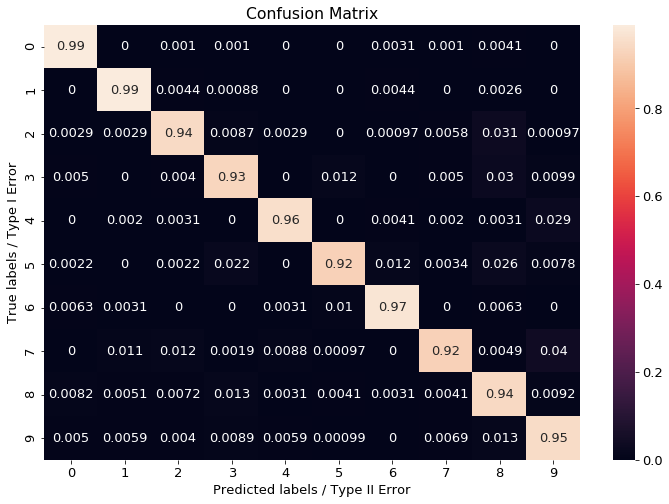

In [0]:
# graph confusion matrix for test labels and predicted labels. 
from sklearn.metrics import confusion_matrix
import seaborn as sn

# create a 2D array representing confusion matrix
arr = confusion_matrix(yt,y_hat)
temp = np.zeros(10)
arr1 = np.zeros((10,10))
for i in range(arr.shape[0]):
  temp[i] = sum(arr[i,:])
  for j in range(arr.shape[1]):
    arr1[i,j] = arr[i,j] / temp[i]

#Display as a heatmap
import matplotlib.pyplot as plt     
# labels, title and ticks
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sn.heatmap(arr1, annot=True, ax=ax,)
ax.set_xlabel('Predicted labels / Type II Error');
ax.set_ylabel('True labels / Type I Error'); 
ax.set_title('Confusion Matrix');
plt.rcParams.update({'font.size': 13})